In [31]:
from transformers import SpeechT5Processor, SpeechT5ForSpeechToText, SpeechT5ForTextToSpeech, SpeechT5HifiGan, set_seed

from datasets import load_dataset
import torch

from IPython.display import Audio

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## 1. Data

In [3]:
dataset = load_dataset("hf-internal-testing/librispeech_asr_demo", "clean", split="validation")
dataset = dataset.sort("id")
sampling_rate = dataset.features["audio"].sampling_rate

Found cached dataset librispeech_asr_demo (/export/home/lium/bdos/.cache/huggingface/datasets/hf-internal-testing___librispeech_asr_demo/clean/2.1.0/d3bc4c2bc2078fcde3ad0f0f635862e4c0fef78ba94c4a34c4c250a097af240b)


#### Audio

In [4]:
example_speech = dataset[40]["audio"]['array']

Audio(example_speech, rate=sampling_rate)

#### Text

In [5]:
example_text = dataset[40]["text"]
example_text

'A MAN SAID TO THE UNIVERSE SIR I EXIST'

#### Process input

In [6]:
processor = SpeechT5Processor.from_pretrained("microsoft/speecht5_asr")

In [7]:
inputs_speech = processor(audio=example_speech, sampling_rate=sampling_rate, return_tensors="pt").to(device)
inputs_text = processor(text=example_text, return_tensors='pt').to(device)

In [8]:
inputs_speech

{'input_values': tensor([[-0.0005, -0.0002, -0.0014,  ...,  0.0008,  0.0009,  0.0009]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], device='cuda:0', dtype=torch.int32)}

In [9]:
inputs_text

{'input_ids': tensor([[ 4, 33,  4, 43, 33, 48,  4, 34, 33, 30, 51,  4, 32, 50,  4, 32, 35, 47,
          4, 61, 48, 30, 62, 47, 54, 34, 47,  4, 34, 30, 54,  4, 30,  4, 47, 69,
         30, 34, 32,  2]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}

## 2. Model

#### Speech

In [10]:
model_stt = SpeechT5ForSpeechToText.from_pretrained("microsoft/speecht5_asr")
model_stt = model_stt.to(device)

In [11]:
predicted_ids_speech = model_stt.generate(**inputs_speech, max_length=100)

#### Text

In [12]:
model_tts = SpeechT5ForTextToSpeech.from_pretrained("microsoft/speecht5_tts")
model_tts = model_tts.to(device)

In [15]:
speaker_embeddings = torch.zeros((1, 512)).to(device)
set_seed(555)

#Or optional, to make the generated text sound better
embeddings_dataset = load_dataset("Matthijs/cmu-arctic-xvectors", split="validation")
speaker_embeddings = torch.tensor(embeddings_dataset[7306]["xvector"]).unsqueeze(0).to(device)

Found cached dataset cmu-arctic-xvectors (/export/home/lium/bdos/.cache/huggingface/datasets/Matthijs___cmu-arctic-xvectors/default/0.0.1/a62fea1f9415e240301ea0042ffad2a3aadf4d1caa7f9a8d9512d631723e781f)


In [16]:
spectrogram = model_tts.generate_speech(inputs_text["input_ids"], speaker_embeddings)

## 3. Outputs

#### Automatic Speech Recognition

In [17]:
transcription = processor.batch_decode(predicted_ids_speech, skip_special_tokens=True)
print(transcription[0])

a man said to the universe sir i exist


#### Tex-to-Speech

In [21]:
vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan")
vocoder = vocoder.to(device)

with torch.no_grad():
    generated_speech = vocoder(spectrogram)
    
Audio(generated_speech.cpu(), rate=sampling_rate)

## 4. Embeddings (Speech separate from Text)

#### Speech

In [22]:
out_stt = model_stt(**inputs_speech, decoder_input_ids=predicted_ids_speech)

In [23]:
speech_embeddings = out_stt.encoder_last_hidden_state

In [24]:
speech_embeddings.shape

torch.Size([1, 232, 768])

#### Text

In [26]:
decoder_input_values = torch.zeros((1, 1024, 80)).to(device) #(batch_size, sequence_length, num_mel_bins)
out_tts = model_tts(**inputs_text, speaker_embeddings=speaker_embeddings, decoder_input_values=decoder_input_values)

In [27]:
text_embeddings = out_tts.encoder_last_hidden_state

In [28]:
text_embeddings.shape

torch.Size([1, 40, 768])

In [29]:
#average...pooling...weighted average...self attention poooling....should be done to put them together...

## 5. Visualization (experiment)

In [41]:
speech_embeddings_vis = speech_embeddings.squeeze(0)
text_embeddings_vis = text_embeddings.squeeze(0)

In [42]:
pca = PCA(n_components=3)

In [43]:
pca_speech = pca.fit_transform(speech_embeddings_vis.cpu().detach().numpy())
pca_text = pca.fit_transform(text_embeddings_vis.cpu().detach().numpy())

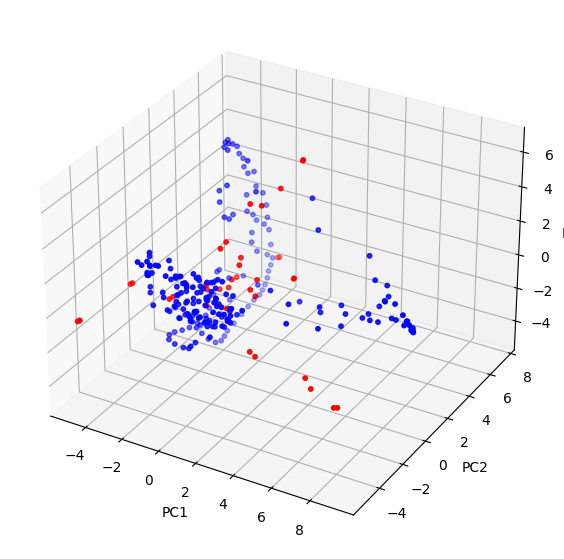

In [44]:
# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = plt.axes(projection="3d")

# Adding points on the 3D plot
ax.scatter3D(pca_speech[:,0], pca_speech[:,1], pca_speech[:,2], s=10, c='b')
ax.scatter3D(pca_text[:,0], pca_text[:,1], pca_text[:,2], s=10, c='r')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()